# The Exploration of Latents of MODIS L2 by Umap

In [91]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [27]:
%matplotlib inline

from importlib import reload
import os
import numpy as np

import pandas

import h5py
import seaborn as sns
import pandas as pd
import umap

from ulmo.analysis import io as analy_io
from ulmo.utils import image_utils
from ulmo import plotting
from ulmo import io as ulmo_io
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [3]:
reload(image_utils)

<module 'ulmo.utils.image_utils' from '/home/jovyan/ulmo/ulmo/utils/image_utils.py'>

In [4]:
### Load the table
evals_path = '/home/jovyan/modis_dataset/MODIS_L2_std.feather'
evals_tbl = ulmo_io.load_main_table(evals_path)

Read main table: /home/jovyan/modis_dataset/MODIS_L2_std.feather


In [5]:
### Check if there exist any 'NaN' values
print(evals_tbl.isna().sum())

lat                      0
lon                      0
col                      0
datetime                 0
LL                  135712
row                      0
clear_fraction           0
mean_temperature         0
Tmin                     0
Tmax                     0
T90                      0
T10                      0
filename                 0
UID                      0
pp_file                  0
pp_root                  0
field_size               0
pp_type                  0
pp_idx                   0
dtype: int64


In [6]:
### Quick try: drop the 'NaN' points
evals_tbl_drop = evals_tbl.dropna()
print(evals_tbl_drop.isna().sum())

lat                 0
lon                 0
col                 0
datetime            0
LL                  0
row                 0
clear_fraction      0
mean_temperature    0
Tmin                0
Tmax                0
T90                 0
T10                 0
filename            0
UID                 0
pp_file             0
pp_root             0
field_size          0
pp_type             0
pp_idx              0
dtype: int64


In [7]:
### Show the example
# field, mask = image_utils.grab_modis_l2_img(example, 'PreProc', ptype='std')

In [8]:
### Load the latents file
lat_file = '/home/jovyan/modis_dataset/' \
           'MODIS_R2019_2019_95clear_128x128_latents_std.h5'

l_h5 = h5py.File(lat_file, 'r')
latents = l_h5['latents']
latents.shape

(751689, 512)

In [9]:
### Show the statistics of several features of the latents
latents_part_df = pd.DataFrame(latents[:, :400])
latents_part_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751689 entries, 0 to 751688
Columns: 400 entries, 0 to 399
dtypes: float32(400)
memory usage: 1.1 GB


In [10]:
latents_part_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,...,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000
mean,0.004975,0.001060,-0.001625,0.007018,0.010252,-0.004330,-0.001359,-0.000082,-0.005402,0.000272,...,0.004499,-0.007422,-0.002398,0.004064,0.010843,0.002954,0.004194,0.000145,-0.011412,-0.006052
std,0.973913,0.983361,0.973651,0.983246,0.985160,0.987386,0.978668,0.982144,0.981116,0.978854,...,0.976631,0.984997,0.980497,0.981389,0.973373,0.979601,0.992584,0.982193,0.985989,0.984063
min,-12.895608,-11.473268,-8.643445,-12.344545,-11.076551,-11.799313,-12.563170,-14.518270,-11.212376,-10.744902,...,-9.777671,-9.955516,-12.292439,-12.638578,-15.550569,-12.391028,-13.237496,-13.111054,-13.853485,-12.878211
25%,-0.488145,-0.524477,-0.541840,-0.476032,-0.495000,-0.493991,-0.497078,-0.496550,-0.538741,-0.501030,...,-0.521854,-0.498464,-0.507808,-0.481324,-0.453612,-0.520528,-0.493105,-0.500887,-0.429397,-0.507753
50%,0.033400,0.002166,-0.038763,0.018280,0.000002,0.008190,0.000602,0.008204,-0.013831,0.020663,...,-0.008118,-0.026581,0.026821,0.004810,0.077684,0.022664,0.007105,0.007249,0.047447,-0.005162
75%,0.539309,0.532241,0.486545,0.512602,0.503973,0.494812,0.495949,0.507855,0.518780,0.522501,...,0.518684,0.478979,0.540610,0.485096,0.558634,0.548474,0.506308,0.503110,0.472975,0.498321
max,9.434946,9.087834,13.096346,9.850948,10.632300,10.975488,11.278859,10.691287,10.463519,12.954918,...,12.420573,10.999012,11.334339,10.844025,7.939140,9.157885,11.574175,10.978301,11.022414,11.049067


<AxesSubplot:ylabel='Count'>

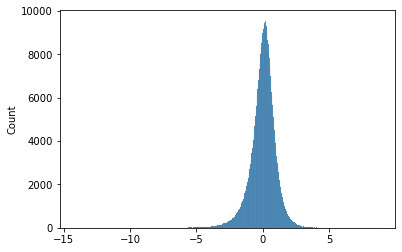

In [13]:
### We will plot the histogram of a randomly selected feature of the latents
seed = 0
np.random.seed(seed)
index_rand = np.random.randint(512)
sns.histplot(latents[:, index_rand])

### From above histograms, we know that all the features of the latents almost belong to the standard normal distribution.

## Let's do linear transformation to standarize the latent vector at first.
### For each component, we do $x_{std} = (x - \mu) / \sigma(x)$.

In [14]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents)
### Transform the latents
latents_std = scaler.transform(latents)

In [15]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

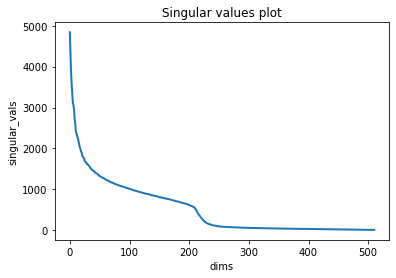

In [16]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

### From above plot, actually we can try to use the $dims = 300$ for the latent space.
### Here we use $dims = 256$.

In [17]:
pca = PCA(n_components=256, random_state=0)
pca.fit(latents_std)
latents_reduced = pca.transform(latents_std)
print(latents_reduced.shape)

(751689, 256)


## In this block, we will take the LL of each Latent vector. (We thank Prof. X for his nice codes for matching.)

In [41]:
### At first let's get the index list of the latent vectors. Here we thank Prof. X for his nice 'matching' codes.
y2019 = evals_tbl.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
### Check the total number of the number of latents
assert np.sum(y2019) == latents.shape[0], 'The index list is not consistent with the latents vector!'
print(f'The total number of latents is: {np.sum(y2019)}.')
### Get the index list of the latent vector
idx = evals_tbl[y2019].pp_idx.values

The total number of latents is: 751689.


### Naively, we just split the latents vectors into two groups according to the LL. 
### More concretely, we will set the latents in the range $[-\Phi^{-1}(\frac{\alpha}{2}), \Phi^{-1}(\frac{\alpha}{2})]$ as the normal points but the points in the range $[-\infty, -\Phi^{-1}(\frac{\alpha}{2})]\bigcup[-\infty, -\Phi^{-1}(\frac{\alpha}{2})]$ as  outliers.

In [43]:
### At first, let's check the statistics of the LL
evals_tbl[y2019].LL.describe()

count    751689.000000
mean        228.834571
std         234.529433
min       -5957.205078
25%          95.118042
50%         243.577942
75%         382.215637
max        1007.517334
Name: LL, dtype: float64

<AxesSubplot:xlabel='LL', ylabel='Count'>

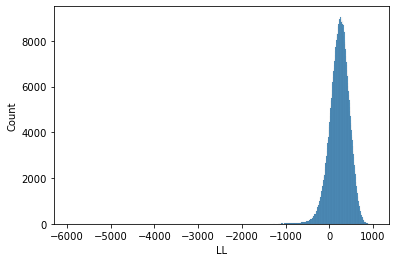

In [44]:
sns.histplot(evals_tbl[y2019].LL)

## Get the quantile of the Empirical PDF (histogram) to determine the threshold

In [114]:
### Get the 'LL' dataframe
LL_pd = evals_tbl[y2019].LL

In [121]:
alpha = 0.999
p_left = (1 - alpha) / 2
p_right = 1 - (1 - alpha) / 2
q_left = LL_pd.quantile(p_left)
q_right = LL_pd.quantile(p_right)
print(f'The left location is: {q_left}.')
print(f'The right location is: {q_right}.')

The left location is: -1548.1938535156248.
The right location is: 837.5729921875064.


In [122]:
### Here we write a funtion 'threshold_get()' to get the left and right threshold
def threshold_get(data_pd, alpha):
    '''
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability

    Output:
        (left_threshold, right_threshold): (tuple (float, float))
    '''
    p_left = (1 - alpha) / 2
    p_right = 1 - (1 - alpha) / 2
    q_left = LL_pd.quantile(p_left)
    q_right = LL_pd.quantile(p_right)
    
    return (q_left, q_right)

In [123]:
### Test of the module 'threshold_get()'
LL_pd = evals_tbl[y2019].LL
alpha = 0.999
q_left, q_right = threshold_get(LL_pd, alpha)
print(f'The left location is: {q_left}.')
print(f'The right location is: {q_right}.')

The left location is: -1548.1938535156248.
The right location is: 837.5729921875064.


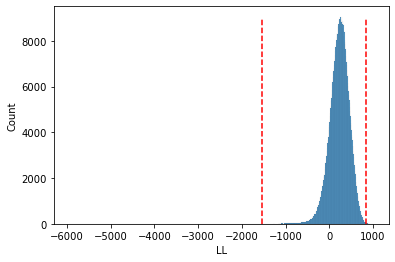

In [139]:
sns.histplot(evals_tbl[y2019].LL)
plt.vlines(x=q_left, ymin=0, ymax=9000, color='red', linestyles='dashed')
plt.vlines(x=q_right, ymin=0, ymax=9000, color='red', linestyles='dashed')

In [173]:
def hist_tail_create(data_pd, alpha):
    '''
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability
    '''
    q_left, q_right = threshold_get(data_pd, alpha)
    sns.histplot(evals_tbl[y2019].LL)
    plt.vlines(x=q_left, ymin=0, ymax=9000, color='red', linestyles='dashed')
    plt.vlines(x=q_right, ymin=0, ymax=9000, color='red', linestyles='dashed')
    plt.xlabel('LL', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.title(f'tail area = 1 - {alpha}', fontsize=25)

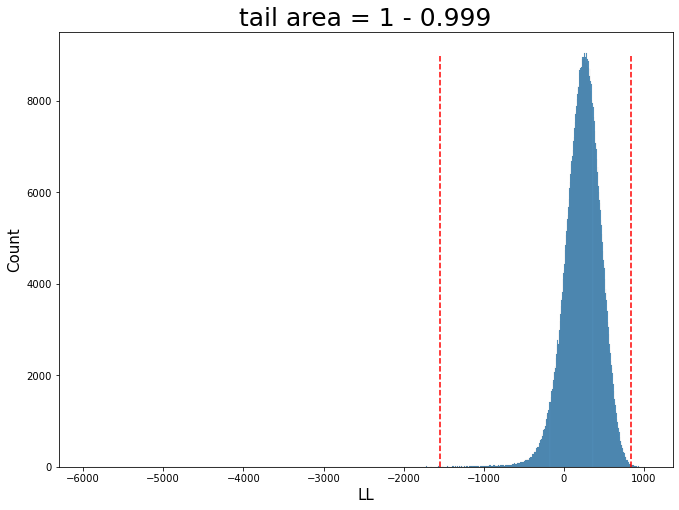

In [174]:
### Test of 'hist_tail_create()' module
ll_pd = evals_tbl[y2019].LL
alpha = 0.999
plt.figure(figsize=(11, 8))
hist_tail_create(ll_pd, alpha)

In [133]:
### Here we write a function 'outliers_preparing()' 
def outliers_preparing(data_pd, alpha):
    '''
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability

    Output:
        (left_outliers_indices, right_outliers_indices, normal_indices): (tuple (list, list, list))
    ''' 
    q_left, q_right = threshold_get(data_pd, alpha)
    ll_latents_np = data_pd.values.copy()
    left_outliers_indices = np.argwhere(ll_latents_np <= q_left).squeeze()
    right_outliers_indices = np.argwhere(ll_latents_np >= q_right).squeeze()
    normal_indices_left = np.argwhere(q_left <= ll_latents_np).squeeze()
    normal_indices_right = np.argwhere(ll_latents_np <= q_right).squeeze()
    normal_indices = np.intersect1d(normal_indices_left, normal_indices_right)
    
    assert len(left_outliers_indices) + len(right_outliers_indices) + len(normal_indices) == len(ll_latents_np), \
        'the result is not consistent!'
    
    return (left_outliers_indices, right_outliers_indices, normal_indices)

In [134]:
### Test of 'outliers_preparing()' module
LL_pd = evals_tbl[y2019].LL
alpha = 0.999
left_outliers_indices, right_outliers_indices, normal_outliers_indices = outliers_preparing(LL_pd, alpha)

## We will use the UMap to explore the latents. 

### Initialize the umap reducer and fit the umap model

In [94]:
%%time
reducer_umap = umap.UMAP()
latents_embedding = reducer_umap.fit_transform(latents_reduced)
print('The shape of the reduced matrix is: ', latents_embedding.shape)
print('The dimension of the embedding manifold is: ', latents_embedding.shape[1])

The shape of the reduced matrix is:  (751689, 2)
The dimension of the embedding manifold is:  2
CPU times: user 10h 43min 36s, sys: 1h 37min 52s, total: 12h 21min 29s
Wall time: 14min 53s


### Create the Scatter Plot of the Reduced Latents Space by UMap

In [179]:
def scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices):
    '''
    Args:
        latents_embedding: (np.array) The array of reduced manifold
        left_outliers_indices: (np.array) The array of left tail indices
        right_outliers_indices: (np.array) The array of right tail indices
        normal_indices: (np.array) The array of normal indices
    '''
    plt.scatter(latents_embedding[:, 0][normal_indices], latents_embedding[:, 1][normal_indices],
            s=12, label='normal')
    plt.scatter(latents_embedding[:, 0][left_outliers_indices], latents_embedding[:, 1][left_outliers_indices],
            s=30, label='left outliers')
    plt.scatter(latents_embedding[:, 0][right_outliers_indices], latents_embedding[:, 1][right_outliers_indices],
            s=30, label='right outliers')
    plt.xlabel('1st dimension', fontsize=15)
    plt.ylabel('2ed dimension', fontsize=15)
    plt.legend(fontsize=15, loc=1)
    plt.title('Scatter plot of embedding manifold by UMAP', fontsize=25)

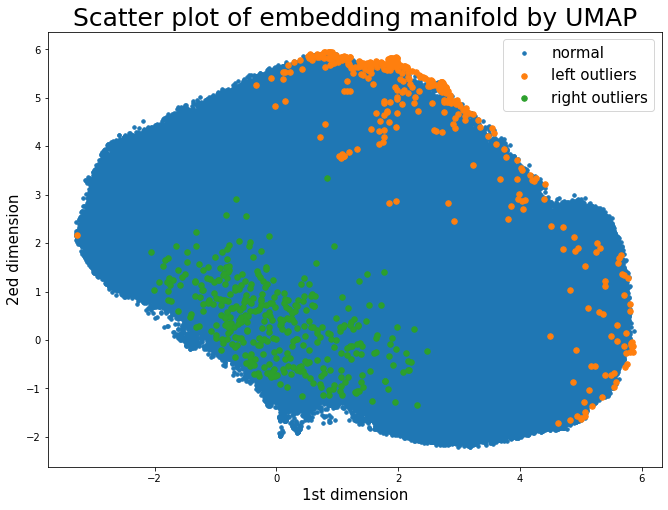

In [180]:
### Test the 'scatter_create()' module
LL_pd = evals_tbl[y2019].LL
alpha = 0.999
plt.figure(figsize=(11, 8))
left_outliers_indices, right_outliers_indices, normal_indices = outliers_preparing(LL_pd, alpha)
scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices)

### Create the Hist and the Scatter plot at the same time

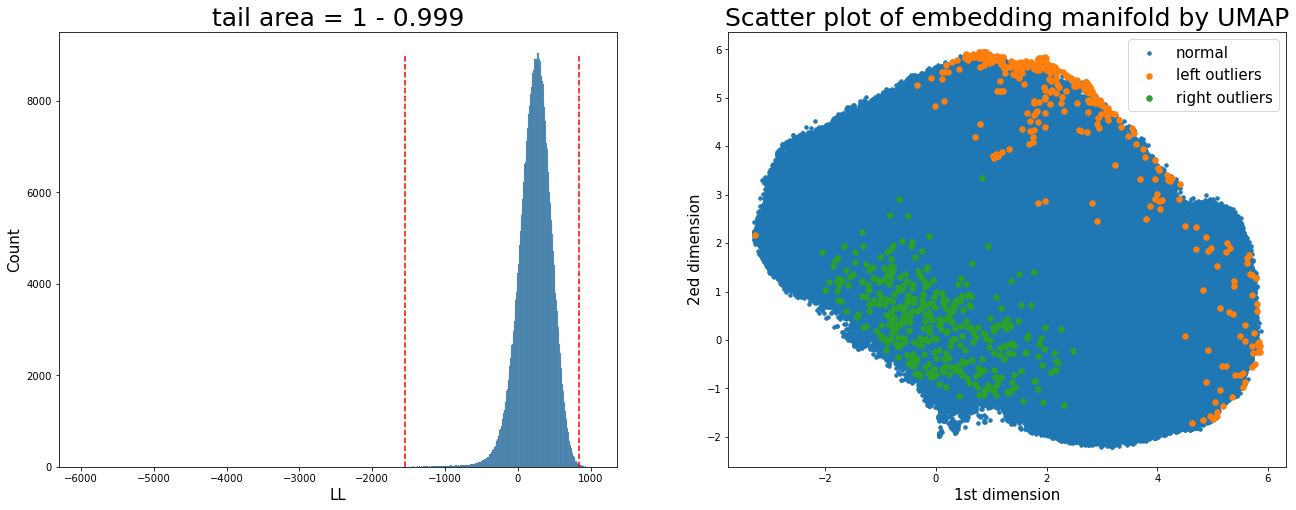

In [181]:
plt.figure(figsize=(22, 8))
ll_pd = evals_tbl[y2019].LL
alpha = 0.999
plt.subplot(1, 2, 1)
hist_tail_create(ll_pd, alpha)
plt.subplot(1, 2, 2)
left_outliers_indices, right_outliers_indices, normal_indices = outliers_preparing(LL_pd, alpha)
scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices)

## Create the two plots with tail area equals $1 - \alpha = 0.0001$

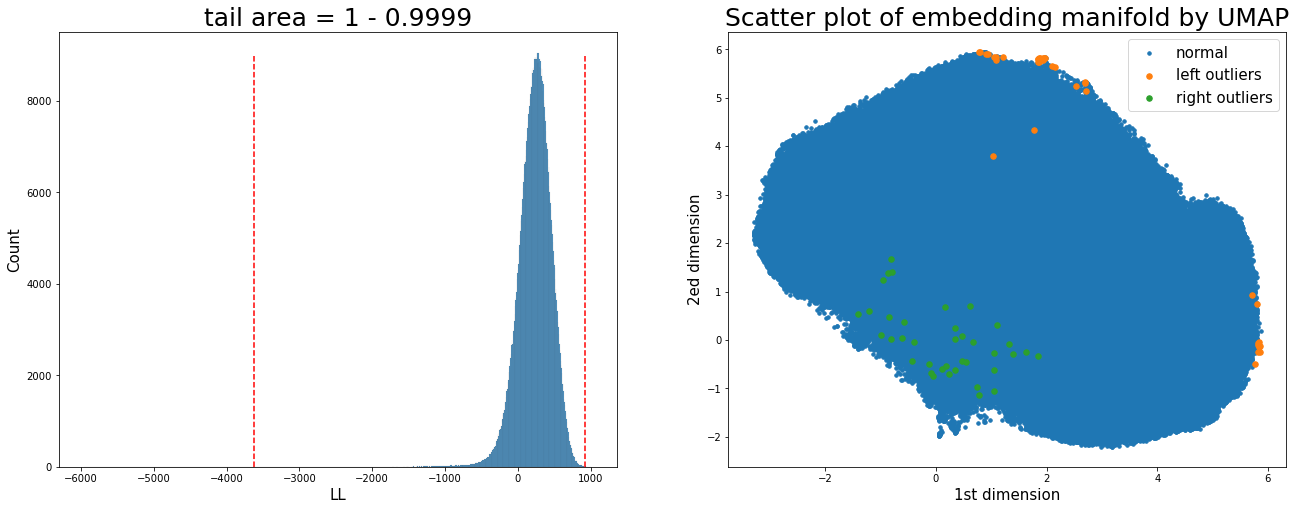

In [182]:
plt.figure(figsize=(22, 8))
ll_pd = evals_tbl[y2019].LL
alpha = 0.9999
plt.subplot(1, 2, 1)
hist_tail_create(ll_pd, alpha)
plt.subplot(1, 2, 2)
left_outliers_indices, right_outliers_indices, normal_indices = outliers_preparing(LL_pd, alpha)
scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices)

## Create the two plots with tail area equals $1 - \alpha = 0.01$

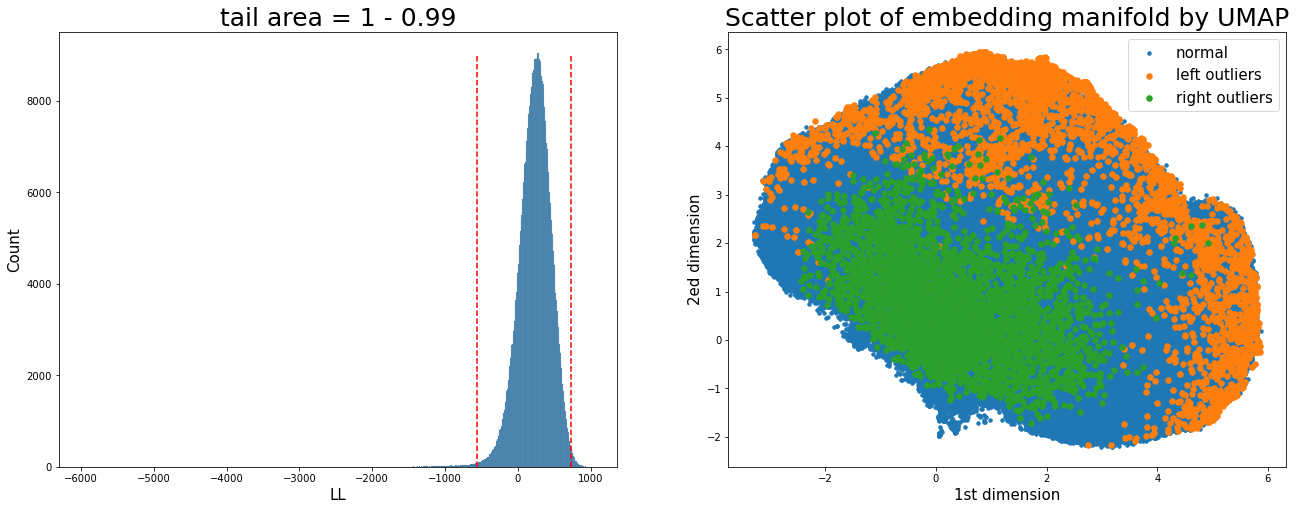

In [184]:
plt.figure(figsize=(22, 8))
ll_pd = evals_tbl[y2019].LL
alpha = 0.99
plt.subplot(1, 2, 1)
hist_tail_create(ll_pd, alpha)
plt.subplot(1, 2, 2)
left_outliers_indices, right_outliers_indices, normal_indices = outliers_preparing(LL_pd, alpha)
scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices)

## Create the two plots with tail area equals $1 - \alpha = 0.005$

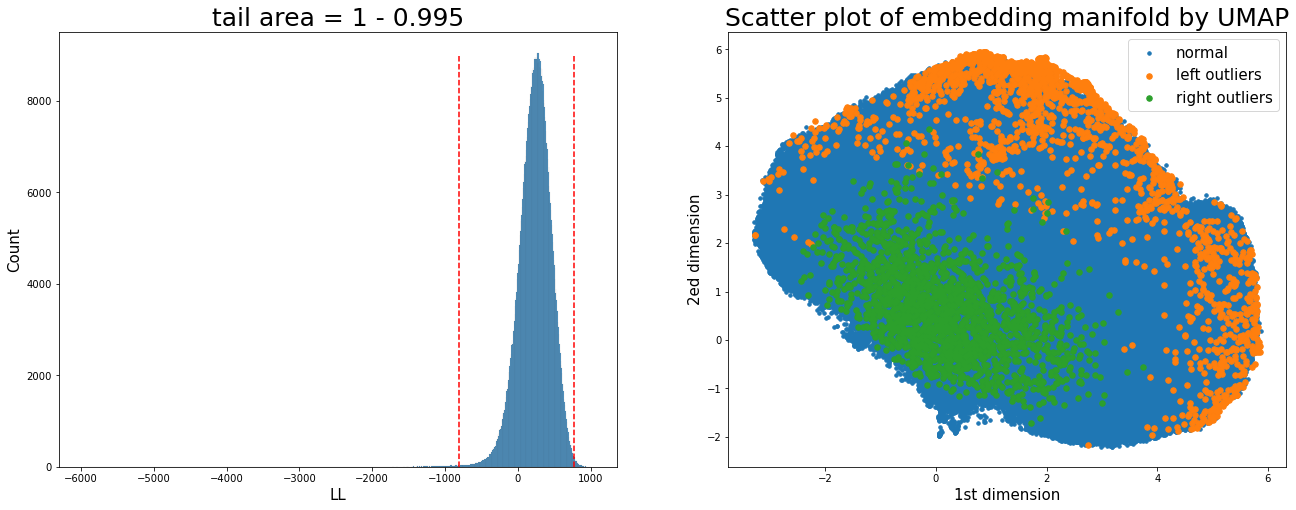

In [185]:
plt.figure(figsize=(22, 8))
ll_pd = evals_tbl[y2019].LL
alpha = 0.995
plt.subplot(1, 2, 1)
hist_tail_create(ll_pd, alpha)
plt.subplot(1, 2, 2)
left_outliers_indices, right_outliers_indices, normal_indices = outliers_preparing(LL_pd, alpha)
scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices)

## Create the two plots with tail area equals $1 - \alpha = 0.0005$

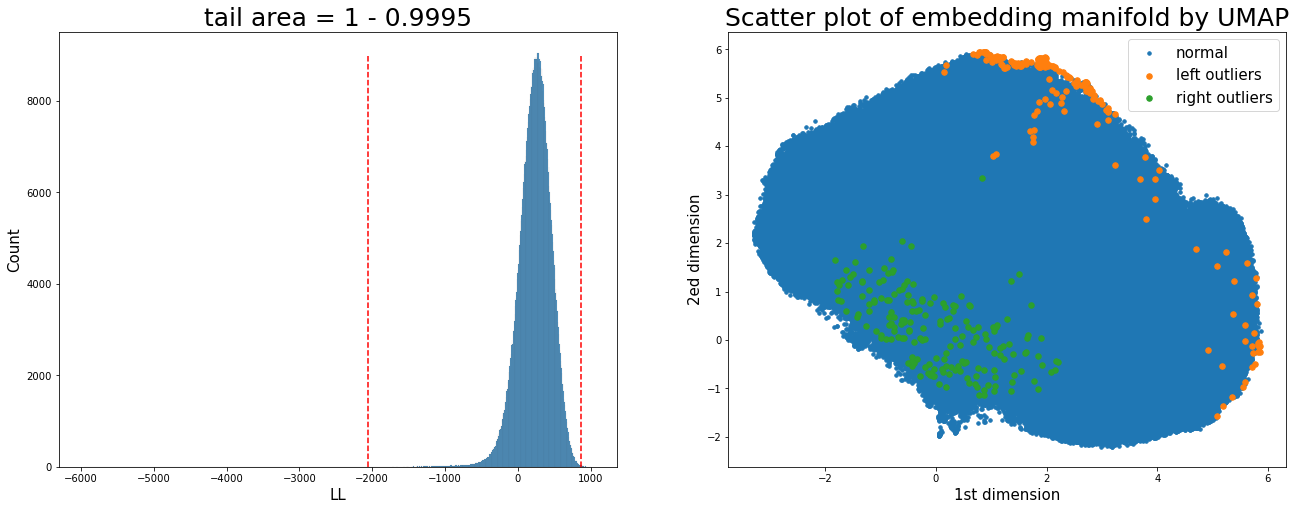

In [187]:
plt.figure(figsize=(22, 8))
ll_pd = evals_tbl[y2019].LL
alpha = 0.9995
plt.subplot(1, 2, 1)
hist_tail_create(ll_pd, alpha)
plt.subplot(1, 2, 2)
left_outliers_indices, right_outliers_indices, normal_indices = outliers_preparing(LL_pd, alpha)
scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices)

## Make the scatter plot of reduced manifold with colorbar

Text(0.5, 1.0, 'Scatter plot of embedding manifold by UMAP')

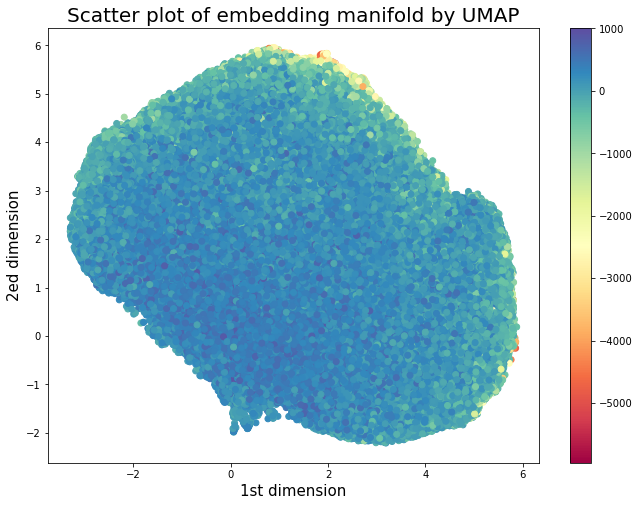

In [192]:
plt.figure(figsize=(11, 8))
plt.scatter(latents_embedding[:, 0], latents_embedding[:, 1], c=ll_pd.values, cmap='Spectral')
plt.colorbar()
plt.xlabel('1st dimension', fontsize=15)
plt.ylabel('2ed dimension', fontsize=15)
plt.title('Scatter plot of embedding manifold by UMAP', fontsize=20)